# 1 | Import Libraries

In [31]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps


In [32]:
import os
os.environ["KERAS_BACKEND"] = "jax" 

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 
from kaggle_secrets import UserSecretsClient
import wandb

# Setup user secrets for login
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("api_key")
wandb.login(key=wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [33]:
#Initialising the Wandb run
run = wandb.init(project="hmskaggle")

# 2 | Configuration

In [53]:
class CFG:
    verbose = 1  
    seed = 42  # Random seed
    image_size = [400, 300]  # Input image size
    epochs = 100 # Training epochs
    batch_size= 64  # Batch size
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}
    train = False

# 3 | Reproducibility
Sets value for random seed to produce similar result in each run.

In [54]:
keras.utils.set_random_seed(CFG.seed)

# 4 | Dataset Path

In [36]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)

 # 5 | Meta Data
 
 train.csv Metadata for the train set. The expert annotators reviewed 50 second long EEG samples plus matched spectrograms covering 10 a minute window centered at the same time and labeled the central 10 seconds. Many of these samples overlapped and have been consolidated. train.csv provides the metadata that allows you to extract the original subsets that the raters annotated.

* eeg_id - A unique identifier for the entire EEG recording.
* eeg_sub_id - An ID for the specific 50 second long subsample this row's labels apply to.
* eeg_label_offset_seconds - The time between the beginning of the consolidated EEG and this subsample.
* spectrogram_id - A unique identifier for the entire EEG recording.
* spectrogram_sub_id - An ID for the specific 10 minute subsample this row's labels apply to.
* spectogram_label_offset_seconds - The time between the beginning of the consolidated spectrogram and this subsample.
* label_id - An ID for this set of labels.
* patient_id - An ID for the patient who donated the data.
* expert_consensus - The consensus annotator label. Provided for convenience only.
[seizure/lpd/gpd/lrda/grda/other]_vote - The count of annotator votes for a given brain activity class. The full names of the activity classes are as follows: lpd: lateralized periodic discharges, gpd: generalized periodic discharges, lrd: lateralized rhythmic delta activity, and grda: generalized rhythmic delta activity

In [37]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


In [38]:
table = wandb.Table(data=df)
run.log({'data':table})
run.finish()

## Convert .parquet to .npy
To facilitate easier data loading, we will convert the EEG spectrograms from parquet to npy format. This process involves saving the spectrogram data, and since the content of the files remains the same, no significant changes are made.

> It's worth noting that the time column is excluded, as it is not part of the spectrogram.

In [39]:
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

In [42]:
spec_ids.shape

(11138,)

# 6| DataLoader
This DataLoader first reads npy spectrogram files and extracts labeled subsamples using specified offset values. Then, it converts the spectrogram data into log spectrogram and applies the popular signal augmentation MixUp.

> Note that, we are converting the mono channel signal to a 3-channel signal for using "ImageNet" weights of pretrained model.

In [40]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),

    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [43]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

In [44]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

In [45]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


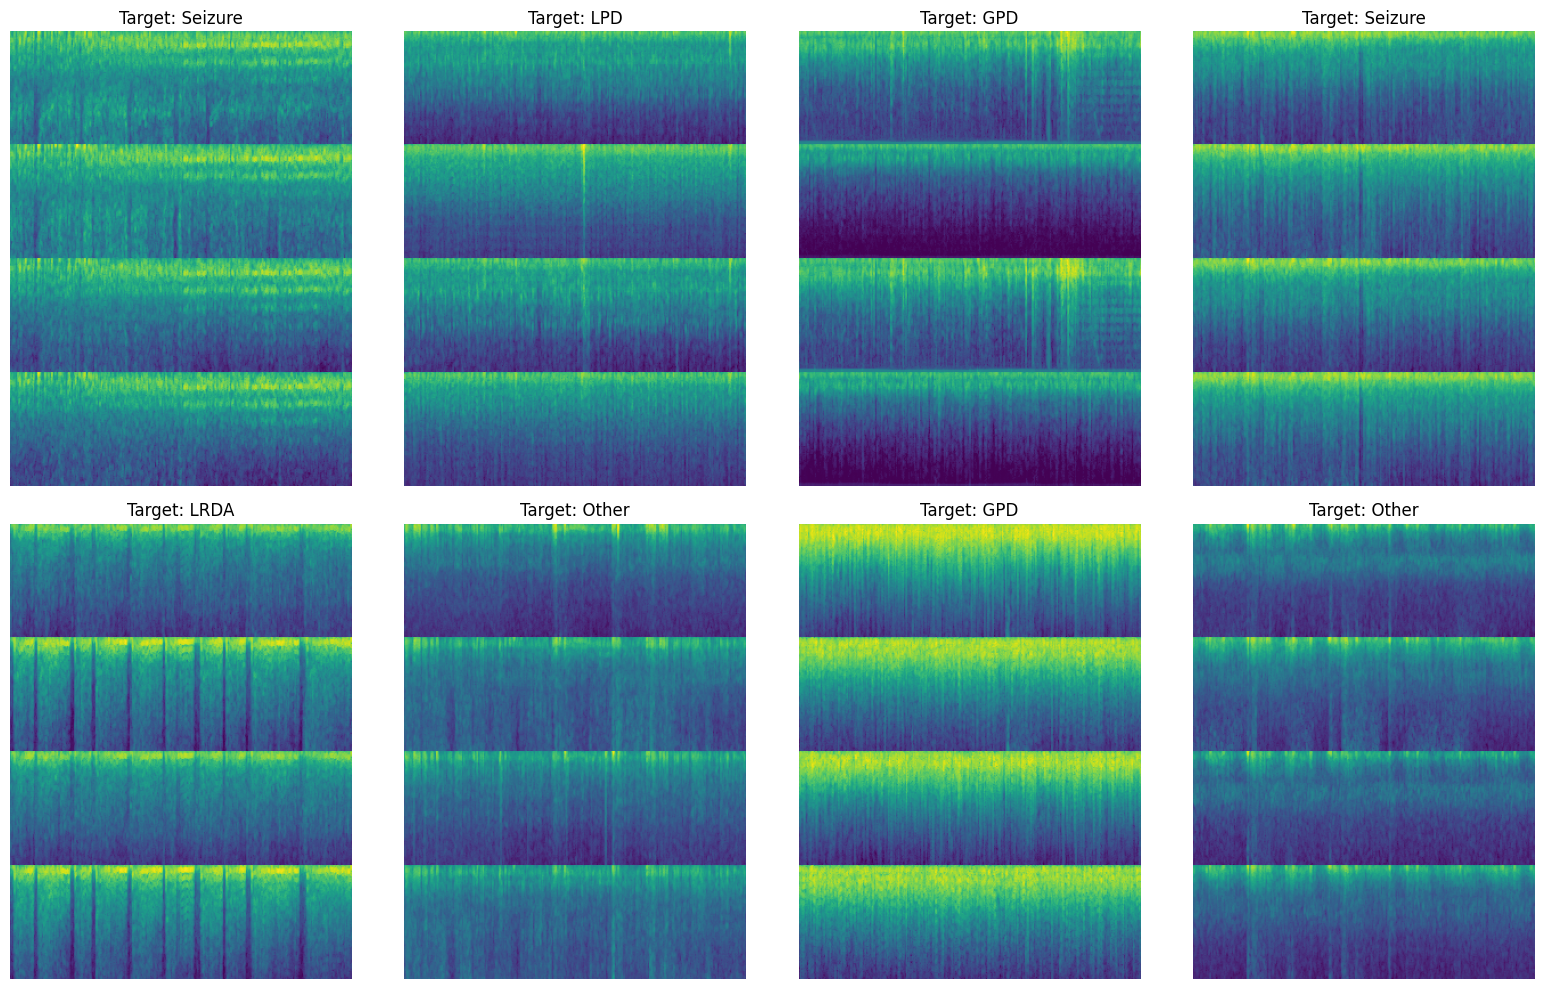

In [ ]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# 7| Loss & Metric

The evaluation metric in this competition is **KL Divergence**, defined as,

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- $P$ is the true distribution.
- $Q$ is the predicted distribution.

Interestingly, as KL Divergence is differentiable, we can directly use it as our loss function. Thus, we don't need to use a third-party metric like **Accuracy** to evaluate our model. Therefore, `valid_loss` can stand alone as an indicator for our evaluation. In keras, we already have impelementation for KL Divergence loss so we only need to import it.

In [77]:
def custom_kl_divergence(y_true, y_pred):
    # Ensure the prediction is not zero
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1)
    # Ensure the true label is not zero
    y_true = tf.clip_by_value(y_true, tf.keras.backend.epsilon(), 1)
    # Calculate KL Divergence
    kl_divergence = tf.reduce_sum(y_true * tf.math.log(y_true / y_pred), axis=-1)
    return kl_divergence

# Usage with a Keras model
LOSS = custom_kl_divergence

opt = keras.optimizers.Adam(learning_rate=1e-4)

# 8 | Modeling: Mix Transfomer


This architecture was presented in [SegFormer: Simple and Efficient Design for Semantic
Segmentation with Transformers](#https://arxiv.org/pdf/2105.15203.pdf). It  represents a significant advancement in the field of semantic segmentation using Transformer models. This section aims to continue the presentation of the model by discussing its key components and how it leverages the Mix Transformer (MiT) backbone for effective segmentation tasks.

## Key Components of SegFormer
SegFormer consists of two main components:

* **MiT Backbone**: The Mix Transformer (MiT) backbone serves as the feature extractor. Unlike traditional Convolutional Neural Networks (CNNs) used in semantic segmentation, the MiT backbone uses a hierarchical structure with multiple stages to process the input image at different resolutions. This approach allows the model to capture both fine details and global context efficiently.

* *MLP Decoder*: The MLP (Multilayer Perceptron) Decoder is lightweight and designed to aggregate the multi-level feature maps produced by the MiT backbone. It utilizes a series of linear layers and upsampling to generate the final segmentation map from the extracted features. This design choice reduces the computational cost while maintaining high segmentation performance.

## Advantages of Mix Transformer
* **Efficiency** : The hierarchical nature of the MiT backbone, combined with the lightweight MLP decoder, makes SegFormer efficient in terms of both computational resources and memory usage. This allows it to run faster and be more scalable than many previous segmentation models.

* **Versatility** : SegFormer is designed to be effective across a wide range of semantic segmentation tasks and datasets. Its ability to capture multi-scale features makes it particularly well-suited for diverse and challenging segmentation scenarios.

* **Simplicity** : Despite its effectiveness, the SegFormer model maintains a simple architecture. This simplicity facilitates easier understanding, implementation, and customization for specific applications.



In [48]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [49]:
from wandb.keras import WandbMetricsLogger
wandb.init(project="hmskaggle")

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models

def PatchAndEmbed(input_shape, patch_size, embed_dim, name):
    inputs = layers.Input(shape=input_shape)
    
    # Assuming the use of overlapping patches, though this is a simplified version
    # In the actual implementation, consider using a custom layer or adjusting strides for overlapping
    patches = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size//2, padding='same', name=f"{name}_patch_embed")(inputs)
    batch_size, height, width, channels = patches.shape
    patches = layers.Reshape((height * width, channels))(patches)
    
    return models.Model(inputs, patches, name=f"{name}_patch_and_embed")

def TransformerEncoderBlock(embed_dim, num_heads, ff_dim, name):
    inputs = layers.Input(shape=(None, embed_dim))
    
    # Layer Normalization 1
    ln1 = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-Head Attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(ln1, ln1)
    # Skip Connection
    out1 = layers.Add()([inputs, attn])
    
    # Layer Normalization 2
    ln2 = layers.LayerNormalization(epsilon=1e-6)(out1)
    # Feed Forward Network
    ff = layers.Dense(ff_dim, activation='relu')(ln2)
    ff = layers.Dense(embed_dim)(ff)
    # Skip Connection
    out2 = layers.Add()([out1, ff])
    
    return models.Model(inputs, out2, name=f"{name}_transformer_encoder_block")

def HierarchicalTransformerEncoder(patch_and_embed_model, depth, embed_dim, num_heads, ff_dim, name):
    inputs = layers.Input(shape=patch_and_embed_model.output_shape[1:])
    
    x = inputs
    for i in range(depth):
        x = TransformerEncoderBlock(embed_dim, num_heads, ff_dim, name=f"{name}_{i}")(x)
    
    # Note: In actual implementation, consider output reshaping or pooling as per requirements
    return models.Model(inputs, x, name=f"{name}_hierarchical_encoder")

def MiTBackbone(input_shape, num_levels=4, depth_per_level=2, initial_patch_size=4, initial_embed_dim=32, ff_dim=128, num_heads=4):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Rescaling(1./255, name="rescaling")(inputs)
    for level in range(num_levels):
        patch_size = initial_patch_size * (2 ** level)
        embed_dim = initial_embed_dim * (2 ** level)
        patch_and_embed = PatchAndEmbed(input_shape, patch_size, embed_dim, name=f"patch_and_embed_{level}")
        if level == 0:
            x = patch_and_embed(x)
        else:
            reshaped_x = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, embed_dim))(x)
            x = patch_and_embed(reshaped_x)
        
        hierarchical_encoder = HierarchicalTransformerEncoder(patch_and_embed, depth_per_level, embed_dim, num_heads, ff_dim, name=f"hierarchical_encoder_{level}")
        x = hierarchical_encoder(x)
        # Reshape or process output for next level or final output
        # This part is simplified; adjust based on actual model's output processing
    
    # Final layers for classification, segmentation, etc., can be added based on task
    
    return models.Model(inputs, x, name="mi_t_backbone")




In [50]:
from keras import Sequential
# Build Classifier
layer = keras_cv.models.MiTBackbone.from_preset('mit_b0')

model = Sequential([
    keras.layers.Input(shape=(400,300,3)),
    keras.layers.Resizing(224,224,interpolation="bilinear"),
    layer,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6,activation="softmax", dtype=tf.float32)
])

# Compile the model  
model.compile(optimizer=opt,
              loss=LOSS)

# Model Sumamry
model.summary()

Attaching 'config.json' from model 'keras/mit/keras/mit_b0/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/mit/keras/mit_b0/2' to your Kaggle notebook...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ mi_t_backbone (MiTBackbone)     │ (None, 7, 7, 256)         │  3,319,392 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 256)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_48 (Dense)                │ (None, 6)                 │      1,542 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,320,934 (12.67 MB)

 Trainable params: 3,320,934 (12.67 MB)

 Non-trainable params: 0 (0.00 B)

# 9 | LR Schedule
A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

# 10| Model Checkpointing

In [78]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

# 11 | Training

In [ ]:
if CFG.train:
    history = model.fit(
        train_ds, 
        epochs=CFG.epochs,
        callbacks=[ ckpt_cb,WandbMetricsLogger()], 
        steps_per_epoch=len(train_df)//CFG.batch_size,
        validation_data=valid_ds, 
        verbose=CFG.verbose
    )

# 12| Prediction

In [64]:
# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


In [56]:
model.load_weights("/kaggle/input/kerascv-hms-mit/model.weights.h5")

In [65]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

In [66]:
test_df

,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


In [67]:
preds = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
